In [83]:
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from sklearn.model_selection import train_test_split
from model.loss_functions.RMSELoss import RMSELoss
from utils.dataset_utils import DatasetUtils

In [2]:
# Define constants
START_DATE_BOARD = '2022-11-03'
END_DATE_BOARD = '2023-06-15'
RANDOM_STATE = 42

## Benchmark Loss
The goal of this notebook is to compute the same loss of the 3 models (LSTM, ANN, VQR) in the same portion of test set. The result will be the benchmark that each model has to overcome.

### LSTM model
Best hyperparams:
- optimizer: ADAM
- criterion: L1
- learning rate: 0.001
- num epochs: 450
- hidden size: 600
- T: 3
- train size: 15%

Final loss on test set: 2.7362

### ANN model
Best hyperparams:
- optmizier: SGD
- criterion: L1
- learning rate: 0.0001
- num epochs: 200
- hidden size: 60
- hidden size layer 2: ?
- hidden size layer 3: ?
- train size: 70%

Final loss on test set: 5.3008

### VQR Non linear model
Best hyperparams:
- optmizier: 
- criterion: 
- learning rate: 
- num epochs: 
- num layers: 
- train size: 70%

Final loss on test set:

In [3]:
# Define best hyperparams for LSTM
TRAIN_SIZE      = 0.15
CRITERION_L1    = nn.L1Loss()
CRITERION_RMSE  = RMSELoss()
CRITERION_MSE  = nn.MSELoss()

#### Build the same dataset

In [4]:
df_sensors = pd.read_csv('../resources/dataset/unique_timeseries_by_median_hours.csv')
df_sensors.timestamp = pd.to_datetime(df_sensors.timestamp)
df_sensors.timestamp += pd.Timedelta(hours=1)
df_arpa = DatasetUtils.build_arpa_dataset('../resources/dataset/arpa/Dati PM10_PM2.5_2020-2022.csv', '../resources/dataset/arpa/Torino-Rubino_Polveri-sottili_2023-01-01_2023-06-30.csv', START_DATE_BOARD, END_DATE_BOARD)

df = df_sensors.merge(df_arpa, left_on=['timestamp'], right_on=['timestamp'])
df.rename(columns={"data": "x", "pm25": "y"}, inplace=True)
# Slide ARPA data 1 hour plus
df['y'] = DatasetUtils.slide_plus_1hours(df['y'], df['x'][0])
X = df.x.values
y = df.y.values
_, X_test, _, y_test = train_test_split(X, y, train_size=TRAIN_SIZE,
                                                    shuffle=False,
                                                    random_state=RANDOM_STATE)

#### Compute the loss

In [5]:
CRITERION_L1(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()

6.639176368713379

In [6]:
CRITERION_RMSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()

9.218208312988281

In [7]:
CRITERION_MSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()

84.97535705566406

## Benchmark Loss distribution

### ANN

In [121]:
TRAIN_SIZE      = 0.70
df_sensors = pd.read_csv('../resources/dataset/unique_timeseries_by_median_hours.csv')
df_sensors.timestamp = pd.to_datetime(df_sensors.timestamp)
df_sensors.timestamp += pd.Timedelta(hours=1)
df_arpa = DatasetUtils.build_arpa_dataset('../resources/dataset/arpa/Dati PM10_PM2.5_2020-2022.csv', '../resources/dataset/arpa/Torino-Rubino_Polveri-sottili_2023-01-01_2023-06-30.csv', START_DATE_BOARD, END_DATE_BOARD)

df = df_sensors.merge(df_arpa, left_on=['timestamp'], right_on=['timestamp'])
df.rename(columns={"data": "x", "pm25": "y"}, inplace=True)
# Slide ARPA data 1 hour plus
df['y'] = DatasetUtils.slide_plus_1hours(df['y'], df['x'][0])
X = df.x.values
y = df.y.values

In [122]:
l1_loss = []
rmse_loss = []
mse_loss = []
for i in range(0, 10000):
    _, X_test, _, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, shuffle=True)
    l1 = CRITERION_L1(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    rmse = CRITERION_RMSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    mse = CRITERION_MSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    l1_loss.append(l1)
    rmse_loss.append(rmse)
    mse_loss.append(mse)
df_benchmark_distribution = pd.DataFrame(columns=['l1', 'rmse', 'mse'])
df_benchmark_distribution['l1'] = l1_loss
df_benchmark_distribution['rmse'] = rmse_loss
df_benchmark_distribution['mse'] = mse_loss

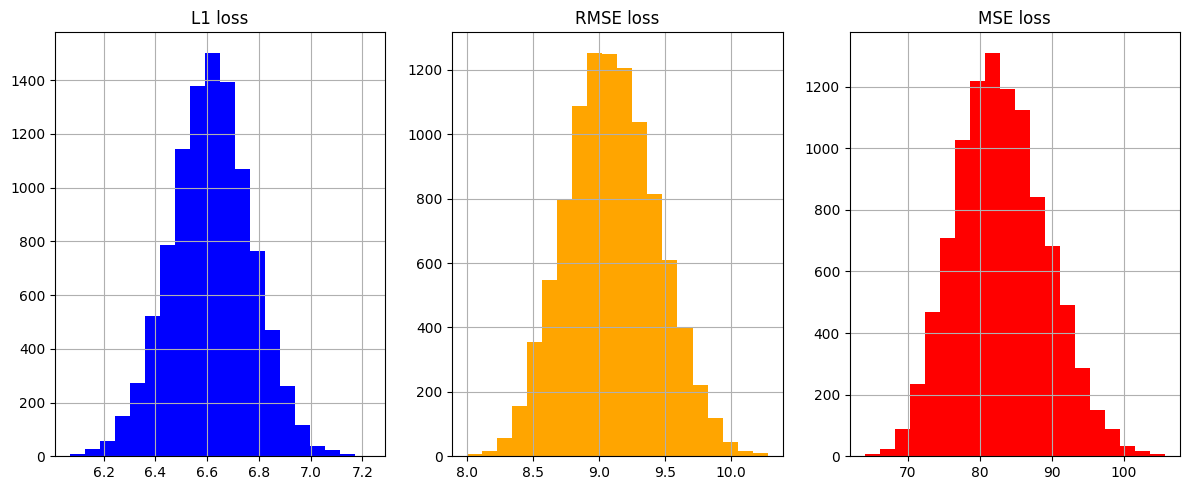

In [123]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
df_benchmark_distribution['l1'].hist(bins=20, ax=ax[0], color='blue')
df_benchmark_distribution['rmse'].hist(bins=20, ax=ax[1], color='orange')
df_benchmark_distribution['mse'].hist(bins=20, ax=ax[2], color='red')
ax[0].set_title('L1 loss')
ax[1].set_title('RMSE loss')
ax[2].set_title('MSE loss')
fig.tight_layout()
plt.show()

### VQR

In [115]:
TRAIN_SIZE      = 0.75

In [116]:
l1_loss = []
rmse_loss = []
mse_loss = []
for i in range(0, 10000):
    _, X_test, _, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, shuffle=True)
    l1 = CRITERION_L1(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    rmse = CRITERION_RMSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    mse = CRITERION_MSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    l1_loss.append(l1)
    rmse_loss.append(rmse)
    mse_loss.append(mse)
df_benchmark_distribution = pd.DataFrame(columns=['l1', 'rmse', 'mse'])
df_benchmark_distribution['l1'] = l1_loss
df_benchmark_distribution['rmse'] = rmse_loss
df_benchmark_distribution['mse'] = mse_loss

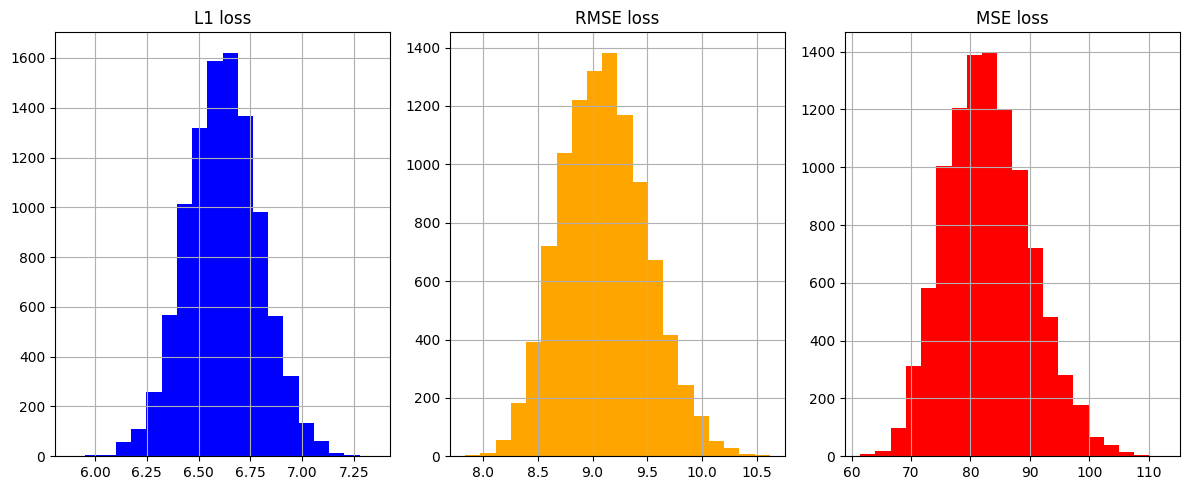

In [120]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
df_benchmark_distribution['l1'].hist(bins=20, ax=ax[0], color='blue')
df_benchmark_distribution['rmse'].hist(bins=20, ax=ax[1], color='orange')
df_benchmark_distribution['mse'].hist(bins=20, ax=ax[2], color='red')
ax[0].set_title('L1 loss')
ax[1].set_title('RMSE loss')
ax[2].set_title('MSE loss')
fig.tight_layout()
plt.show()

### LSTM

In [112]:
TRAIN_SIZE      = 0.15

In [113]:
l1_loss = []
rmse_loss = []
mse_loss = []
for i in range(0, 10000):
    _, X_test, _, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, shuffle=False)
    l1 = CRITERION_L1(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    rmse = CRITERION_RMSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    mse = CRITERION_MSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    l1_loss.append(l1)
    rmse_loss.append(rmse)
    mse_loss.append(mse)
df_benchmark_distribution = pd.DataFrame(columns=['l1', 'rmse', 'mse'])
df_benchmark_distribution['l1'] = l1_loss
df_benchmark_distribution['rmse'] = rmse_loss
df_benchmark_distribution['mse'] = mse_loss

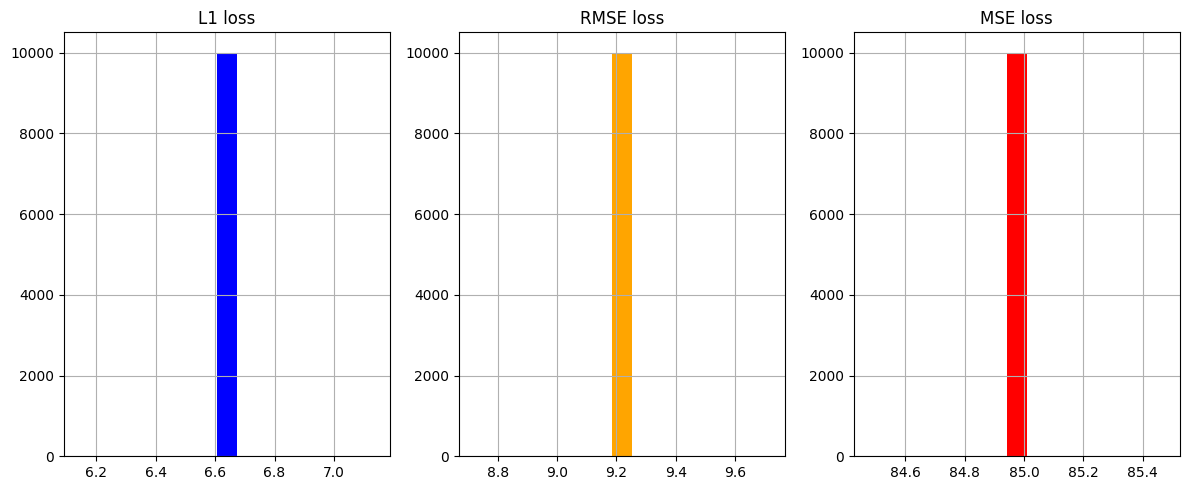

In [114]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
df_benchmark_distribution['l1'].hist(bins=15, ax=ax[0], color='blue')
df_benchmark_distribution['rmse'].hist(bins=15, ax=ax[1], color='orange')
df_benchmark_distribution['mse'].hist(bins=15, ax=ax[2], color='red')
ax[0].set_title('L1 loss')
ax[1].set_title('RMSE loss')
ax[2].set_title('MSE loss')
fig.tight_layout()
plt.show()

Make the same with ShuffleSplit library

In [97]:
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(n_splits=10000, train_size=TRAIN_SIZE)
dataset = df[['x', 'y']]
l1_loss = []
rmse_loss = []
mse_loss = []

for _, test_index in ss.split(dataset):
    X_test = dataset.iloc[test_index].x.to_numpy()
    y_test = dataset.iloc[test_index].y.to_numpy()
    l1 = CRITERION_L1(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    rmse = CRITERION_RMSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    mse = CRITERION_MSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    l1_loss.append(l1)
    rmse_loss.append(rmse)
    mse_loss.append(mse)

In [98]:
df_benchmark_distribution = pd.DataFrame(columns=['l1', 'rmse', 'mse'])
df_benchmark_distribution['l1'] = l1_loss
df_benchmark_distribution['rmse'] = rmse_loss
df_benchmark_distribution['mse'] = mse_loss

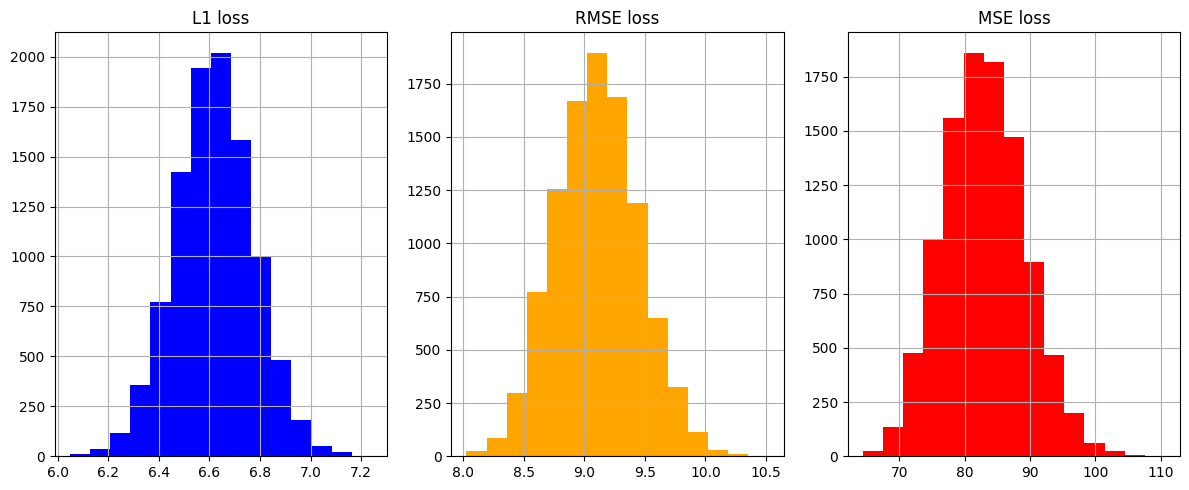

In [99]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
df_benchmark_distribution['l1'].hist(bins=15, ax=ax[0], color='blue')
df_benchmark_distribution['rmse'].hist(bins=15, ax=ax[1], color='orange')
df_benchmark_distribution['mse'].hist(bins=15, ax=ax[2], color='red')
ax[0].set_title('L1 loss')
ax[1].set_title('RMSE loss')
ax[2].set_title('MSE loss')
fig.tight_layout()
plt.show()